In [1]:
import numpy as np
import trace_gen as tg # source code at: https://github.com/Effygal/trace-gen
import matplotlib.pyplot as plt
import heapq
import seaborn as sns
import pandas as pd
import itertools
plt.rcParams['pdf.fonttype'] = 42 
plt.rcParams['ps.fonttype'] = 42 
plt.rcParams['image.cmap'] = 'viridis'
plt.rcParams['text.usetex']  = False
palette = sns.color_palette("deep")
np.random.seed(77)

In [2]:
def gen_from_zipf(M, n, a):
    p = 1.0 / np.power(np.arange(1, M + 1), a)
    p = p / p.sum()
    return np.random.choice(M, size=n, p=p)

def gen_ph(m, theta, length):
    p = 1.0 / np.power(np.arange(1, m + 1), theta)
    p = p / p.sum()
    cp = np.cumsum(p)
    t = p.copy()
    phases = np.searchsorted(cp, np.random.random(m), side="right")
    next_times = np.random.exponential(1.0 / t[phases])
    heap = [(next_times[i], i) for i in range(m)]
    heapq.heapify(heap)
    trace = np.empty(length, dtype=np.int32)
    for idx in range(length):
        ctime, item = heapq.heappop(heap)
        trace[idx] = item + 1
        phases[item] = np.searchsorted(cp, np.random.random(), side="right")
        next_time = ctime + np.random.exponential(1.0 / t[phases[item]])
        heapq.heappush(heap, (next_time, item))
    return trace

def gen_ph_2class(n, theta, ratio, length, mu_ratio=None):
    """
    If mu_ratio is provided, mu1/mu2=mu_ratio with mean inter-arrival 1/2*(1/mu1+1/mu2)=1.
    Otherwise use T=[[-1,0],[0,-ratio]].
    """
    p = 1.0 / np.power(np.arange(1, n + 1), theta)
    p /= p.sum()

    alpha0 = alpha1 = 0.5
    alpha = np.array([alpha0, alpha1], dtype=float)

    if mu_ratio is not None:
        mu2 = (1.0 / mu_ratio + 1.0) / 2.0
        mu1 = mu_ratio * mu2
        T = np.array([[-mu1, 0.0], [0.0, -mu2]], dtype=float)
    elif ratio is not None:
        T = np.array([[-1.0, 0.0], [0.0, -float(ratio)]], dtype=float)
    else:
        raise ValueError("Provide ratio or mu_ratio")

    t = -T.sum(axis=1)
    B = T + t[:, None] * alpha[None, :]
    scale = np.max(-np.diag(B))
    P = B / scale + np.eye(2)
    a = P[0, 1]
    b = P[1, 0]
    if a + b == 0:
        beta = np.array([0.5, 0.5], dtype=float)
    else:
        beta = np.array([b / (a + b), a / (a + b)], dtype=float)
    arate = beta.dot(t)
    T = T / arate
    t = t / arate

    phases = (np.random.random(n) >= alpha0).astype(np.int8)
    rates = t[phases] * p
    next_times = np.random.exponential(1.0 / rates)
    heap = [(next_times[i], i) for i in range(n)]
    heapq.heapify(heap)
    trace = np.empty(length, dtype=np.int32)
    for idx in range(length):
        ctime, item = heapq.heappop(heap)
        trace[idx] = item + 1
        phases[item] = 0 if np.random.random() < alpha0 else 1
        rate = t[phases[item]] * p[item]
        next_time = ctime + np.random.exponential(1.0 / rate)
        heapq.heappush(heap, (next_time, item))
    return trace


In [3]:

def irm_fixed_point_fast(n, theta, cache_size, K=1, tol=1e-15, max_iter=200):
    p = 1.0 / np.power(np.arange(1, n + 1, dtype=np.float64), theta)
    p /= p.sum()
    target = n - float(cache_size)
    if target <= 0:
        return 1.0, np.zeros_like(p), 0.0

    low, high = 0.0, 1.0
    x_minus1 = None
    for _ in range(max_iter):
        z = 0.5 * (low + high)
        r = p / z
        
        denom = np.where(
            np.abs(r - 1.0) < 1e-12,
            K + 2.0,
            (1.0 - r**(K + 2)) / (1.0 - r)
        )
        x_minus1 = 1.0 / denom
        diff = x_minus1.sum() - target
        if high - low <= tol:
            break
        if diff > 0:
            high = z
        else:
            low = z
    pmiss = np.dot(p, 1.0 / denom) 
    return z, x_minus1, pmiss

def he_fixed_point_fast(C, K, n, theta, tol=1e-12, max_iter=60):
    if not (0 < C < n):
        raise ValueError("C must be between 0 and n")
    dtype = np.longdouble if np.finfo(np.longdouble).max > np.finfo(np.float64).max else np.float64
    p = 1.0 / np.power(np.arange(1, n + 1, dtype=np.float64), theta)
    p /= p.sum()
    alpha = p
    inv_p = 1.0 / p
    ones = np.ones(n, float)
    target = 1.0 - C / n
    eps = 1e-15

    def prepare(z):
        di = 1.0 / (p + z)              # 1 ./ (p + z)
        z_di = z * di                  # z ./ (p + z)
        alpha_di = alpha * di
        denom = 1.0 - z * np.dot(alpha, di)
        if abs(denom) < eps:
            denom = eps if denom >= 0 else -eps
        return di, z_di, alpha_di, denom

    def R_dot(v, z, di, z_di, alpha_di, denom):
        # R = z*diag(di) + (z/denom) * (z*di) (alpha*di)^T
        outer_scale = (z / denom) * np.dot(alpha_di, v)
        return z_di * v + outer_scale * z_di

    def solve_eye_minus_R(b, z, di, z_di, alpha_di, denom):
        # Solve (I - R) x = b using Sherman-Morrison on a diagonal + rank-1 matrix.
        B_inv = 1.0 / (1.0 - z_di)  # diagonal inverse of I - z*diag(di)
        u = (z / denom) * z_di
        v = alpha_di
        B_inv_u = B_inv * u
        B_inv_b = B_inv * b
        denom2 = 1.0 - np.dot(v, B_inv_u)
        if abs(denom2) < eps:
            denom2 = eps if denom2 >= 0 else -eps
        return B_inv_b + B_inv_u * (np.dot(v, B_inv_b) / denom2)

    def R_power_vec(v, power, z, di, z_di, alpha_di, denom):
        for _ in range(power):
            v = R_dot(v, z, di, z_di, alpha_di, denom)
        return v

    lo, hi = 1e-12, 0.999999
    z_star = 0.5 * (lo + hi)
    for _ in range(max_iter):
        z_mid = 0.5 * (lo + hi)
        di, z_di, alpha_di, denom = prepare(z_mid)
        theta_k = alpha_di

        tmp_vec = z_mid * R_power_vec(inv_p, K, z_mid, di, z_di, alpha_di, denom)
        w = solve_eye_minus_R(ones, z_mid, di, z_di, alpha_di, denom)
        tmp2 = w - R_power_vec(w, K + 1, z_mid, di, z_di, alpha_di, denom)

        denom_chk = np.dot(theta_k, tmp_vec + tmp2)
        num_chk = np.dot(theta_k, tmp_vec)
        check = num_chk / denom_chk

        if hi - lo <= tol:
            z_star = z_mid
            break
        if check < target:
            lo = z_mid
        else:
            hi = z_mid
        z_star = z_mid

    di, z_di, alpha_di, denom = prepare(z_star)
    theta_k = alpha_di
    tmp_vec = z_star * R_power_vec(inv_p, K, z_star, di, z_di, alpha_di, denom)
    w = solve_eye_minus_R(ones, z_star, di, z_di, alpha_di, denom)
    tmp2 = w - R_power_vec(w, K + 1, z_star, di, z_di, alpha_di, denom)

    denom_base = np.dot(theta_k, tmp_vec + tmp2)
    num_x = np.dot(theta_k, tmp_vec)
    x_minus1_scalar = num_x / denom_base
    x_minus1 = np.full(n, x_minus1_scalar, float)

    rkv_ones = R_power_vec(ones, K, z_star, di, z_di, alpha_di, denom)
    pmiss = n * np.dot(theta_k, z_star * rkv_ones) / denom_base
    return z_star, x_minus1, pmiss


# Two-class PH 
def ph_2class_fixed_point_fast(C, K, n, theta, ratio=None, mu_ratio=None, tol=1e-12, max_iter=60):
    if not (0 < C < n):
        raise ValueError("C must be between 0 and n")
    dtype = np.longdouble if np.finfo(np.longdouble).max > np.finfo(np.float64).max else np.float64
    p = 1.0 / np.power(np.arange(1, n + 1, dtype=dtype), theta, dtype=dtype)
    p /= p.sum(dtype=dtype)

    alpha0 = alpha1 = dtype(0.5)
    alpha_vec = np.array([alpha0, alpha1], dtype=dtype)

    if mu_ratio is not None:
        mu2 = (1.0 / mu_ratio + 1.0) / 2.0
        mu1 = mu_ratio * mu2
        T = np.array([[-mu1, 0.0], [0.0, -mu2]], dtype=dtype)
    elif ratio is not None:
        T = np.array([[-1.0, 0.0], [0.0, -float(ratio)]], dtype=dtype)
    else:
        raise ValueError

    t_vec = -T.sum(axis=1)
    T = T.astype(dtype)
    t_vec = t_vec.astype(dtype)
    B = T + t_vec[:, None] * alpha_vec[None, :]
    scale = np.max(-np.diag(B))
    P = B / scale + np.eye(2)
    denom_stat = P[0, 1] + P[1, 0]
    if abs(denom_stat) < 1e-18:
        beta0 = beta1 = dtype(0.5)
    else:
        beta0 = P[1, 0] / denom_stat
        beta1 = dtype(1.0) - beta0
    arate = beta0 * t_vec[0] + beta1 * t_vec[1]
    T = T / arate
    t_vec = t_vec / arate
    t0, t1 = t_vec
    T00, T11 = T[0, 0], T[1, 1]

    eps = dtype(1e-14)
    clip_val = np.finfo(dtype).max / dtype(4.0)
    target = dtype(n - C)

    def compute_R(z):
        z = dtype(z)
        with np.errstate(over="ignore", invalid="ignore", divide="ignore"):
            a00 = T00 * p - dtype(0.5) * z
            a11 = T11 * p - dtype(0.5) * z
            det = a00 * a11 - (dtype(0.5) * z) ** 2
            det = np.where(np.abs(det) < eps, np.sign(det) * eps + eps, det)
            coef = -z / det
            r00 = coef * a11
            r11 = coef * a00
            off = (z * z * dtype(0.5)) / det
            r01 = off
            r10 = off
            rp00, rp01, rp10, rp11 = r00, r01, r10, r11
            for _ in range(max(K - 1, 0)):
                rp00, rp01, rp10, rp11 = (
                    np.clip(rp00 * r00 + rp01 * r10, -clip_val, clip_val),
                    np.clip(rp00 * r01 + rp01 * r11, -clip_val, clip_val),
                    np.clip(rp10 * r00 + rp11 * r10, -clip_val, clip_val),
                    np.clip(rp10 * r01 + rp11 * r11, -clip_val, clip_val),
                )
            rp00 = np.nan_to_num(rp00, nan=0.0, posinf=clip_val, neginf=-clip_val)
            rp01 = np.nan_to_num(rp01, nan=0.0, posinf=clip_val, neginf=-clip_val)
            rp10 = np.nan_to_num(rp10, nan=0.0, posinf=clip_val, neginf=-clip_val)
            rp11 = np.nan_to_num(rp11, nan=0.0, posinf=clip_val, neginf=-clip_val)
            return (r00, r01, r10, r11), (rp00, rp01, rp10, rp11)

    def check_for_z(z):
        with np.errstate(over="ignore", invalid="ignore", divide="ignore"):
            (r00, r01, r10, r11), (rp00, rp01, rp10, rp11) = compute_R(z)
            inv0 = -dtype(1.0) / (T00 * p)
            inv1 = -dtype(1.0) / (T11 * p)
            th0 = -alpha0 / (T00 * p - z)
            th1 = -alpha1 / (T11 * p - z)

            tmp0 = z * (rp00 * inv0 + rp01 * inv1)
            tmp0 = np.nan_to_num(tmp0, nan=0.0, posinf=clip_val, neginf=-clip_val)
            tmp1 = z * (rp10 * inv0 + rp11 * inv1)
            tmp1 = np.nan_to_num(tmp1, nan=0.0, posinf=clip_val, neginf=-clip_val)

            det_imr = (dtype(1.0) - r00) * (dtype(1.0) - r11) - r01 * r10
            det_imr = np.where(np.abs(det_imr) < eps, np.sign(det_imr) * eps + eps, det_imr)
            inv00 = (dtype(1.0) - r11) / det_imr
            inv01 = r01 / det_imr
            inv10 = r10 / det_imr
            inv11 = (dtype(1.0) - r00) / det_imr
            s0 = inv00 + inv01
            s1 = inv10 + inv11

            pr00 = rp00 * r00 + rp01 * r10
            pr01 = rp00 * r01 + rp01 * r11
            pr10 = rp10 * r00 + rp11 * r10
            pr11 = rp10 * r01 + rp11 * r11
            pr00 = np.clip(pr00, -clip_val, clip_val)
            pr01 = np.clip(pr01, -clip_val, clip_val)
            pr10 = np.clip(pr10, -clip_val, clip_val)
            pr11 = np.clip(pr11, -clip_val, clip_val)
            tmp2_0 = (dtype(1.0) - pr00) * s0 - pr01 * s1
            tmp2_1 = -pr10 * s0 + (dtype(1.0) - pr11) * s1
            tmp2_0 = np.nan_to_num(tmp2_0, nan=0.0, posinf=clip_val, neginf=-clip_val)
            tmp2_1 = np.nan_to_num(tmp2_1, nan=0.0, posinf=clip_val, neginf=-clip_val)

            num = th0 * tmp0 + th1 * tmp1
            den = th0 * (tmp0 + tmp2_0) + th1 * (tmp1 + tmp2_1)
            return np.sum(num / den)

    lo, hi = dtype(1e-12), dtype(0.999999)
    z_star = dtype(0.5) * (lo + hi)
    for _ in range(max_iter):
        z_mid = dtype(0.5) * (lo + hi)
        chk = check_for_z(z_mid)
        if hi - lo <= tol:
            z_star = z_mid
            break
        if chk < target:
            lo = z_mid
        else:
            hi = z_mid
        z_star = z_mid

    (r00, r01, r10, r11), (rp00, rp01, rp10, rp11) = compute_R(z_star)
    inv0 = -dtype(1.0) / (T00 * p)
    inv1 = -dtype(1.0) / (T11 * p)
    th0 = -alpha0 / (T00 * p - z_star)
    th1 = -alpha1 / (T11 * p - z_star)

    det_imr = (dtype(1.0) - r00) * (dtype(1.0) - r11) - r01 * r10
    det_imr = np.where(np.abs(det_imr) < eps, np.sign(det_imr) * eps + eps, det_imr)
    inv00 = (dtype(1.0) - r11) / det_imr
    inv01 = r01 / det_imr
    inv10 = r10 / det_imr
    inv11 = (dtype(1.0) - r00) / det_imr
    s0 = inv00 + inv01
    s1 = inv10 + inv11

    pr00 = rp00 * r00 + rp01 * r10
    pr01 = rp00 * r01 + rp01 * r11
    pr10 = rp10 * r00 + rp11 * r10
    pr11 = rp10 * r01 + rp11 * r11
    pr00 = np.clip(pr00, -clip_val, clip_val)
    pr01 = np.clip(pr01, -clip_val, clip_val)
    pr10 = np.clip(pr10, -clip_val, clip_val)
    pr11 = np.clip(pr11, -clip_val, clip_val)
    tmp2_0 = (dtype(1.0) - pr00) * s0 - pr01 * s1
    tmp2_1 = -pr10 * s0 + (dtype(1.0) - pr11) * s1
    tmp2_0 = np.nan_to_num(tmp2_0, nan=0.0, posinf=clip_val, neginf=-clip_val)
    tmp2_1 = np.nan_to_num(tmp2_1, nan=0.0, posinf=clip_val, neginf=-clip_val)

    tmpM00 = z_star * rp00 * inv0
    tmpM01 = z_star * rp01 * inv1
    tmpM10 = z_star * rp10 * inv0
    tmpM11 = z_star * rp11 * inv1
    tmp_sum0 = tmpM00 + tmpM01
    tmp_sum1 = tmpM10 + tmpM11

    tmpMt0 = tmpM00 * t0 + tmpM01 * t1
    tmpMt1 = tmpM10 * t0 + tmpM11 * t1

    denom_base = th0 * (tmp_sum0 + tmp2_0) + th1 * (tmp_sum1 + tmp2_1)
    num_x = th0 * tmp_sum0 + th1 * tmp_sum1
    x_minus1_scalar = np.sum(num_x / denom_base)
    x_minus1 = np.full(n, x_minus1_scalar, float)

    miss = np.sum((th0 * tmpMt0 + th1 * tmpMt1) * p / denom_base)
    return z_star, x_minus1, miss



In [8]:

# ms = [100, 500, 1000]
ms = [30, 60, 120, 240, 480, 960]
ns = [10000000]
thetas = [0.5, 0.8, 1.1]
ks = [1, 16, 256]
mu_ratio = 10.0
records, errors = [], []

for m in ms:
    for n in ns:
        for a in thetas:
            trace1 = gen_from_zipf(m, n, a)
            # trace2 = gen_ph(m, a, n)
            trace3 = gen_ph_2class(m, a, ratio=None, length=n, mu_ratio=mu_ratio)
            c_vals = np.unique(np.round(np.linspace(m//100+1, m-1, 20)).astype(int))

            for c in c_vals:
                for k in ks:
                    # rclock1 = tg.ran_clock(c, k)
                    # rclock1.run(trace1)
                    # mr_irm_sim = 1 - rclock1.hitrate()
                    mr_irm_sim = 1-tg.sim_ran_clock(c, trace1, raw=False, K=k)


                    # rclock2 = tg.ran_clock(c, k)
                    # rclock2.run(trace2, rp=True)
                    # mr_he_sim = 1 - rclock2.hitrate()

                    # rclock3 = tg.ran_clock(c, k)
                    # rclock3.run(trace3)
                    # mr_ph2_sim = 1 - rclock3.hitrate()
                    mr_ph2_sim = 1-tg.sim_ran_clock(c, trace3, raw=False, K=k)

                    mr_irm_model = irm_fixed_point_fast(m, a, c, K=k)[2]
                    # mr_he_model = he_fixed_point_fast(c, k, m, a)[2]
                    mr_ph2_model = ph_2class_fixed_point_fast(c, k, m, a, mu_ratio=mu_ratio)[2]

                    records.append({
                        "m": m, "n": n, "alpha": a, "C": c, "K": k,
                        "mr_irm_sim": mr_irm_sim,
                        # "mr_he_sim": mr_he_sim,
                        "mr_ph2_sim": mr_ph2_sim,
                        "mr_irm_model": mr_irm_model,
                        # "mr_he_model": mr_he_model,
                        "mr_ph2_model": mr_ph2_model,
                    })

                    errors.append({
                        "m": m, "n": n, "alpha": a, "C": c, "K": k,
                        "error_irm": abs(mr_irm_sim - mr_irm_model),
                        # "error_he": abs(mr_he_sim - mr_he_model),
                        "error_ph2": abs(mr_ph2_sim - mr_ph2_model),
                    })

df_mr = pd.DataFrame(records)
df_err = pd.DataFrame(errors)

/tmp/ipykernel_2246628/3948255107.py:17: RuntimeWarning: overflow encountered in power
  (1.0 - r**(K + 2)) / (1.0 - r)


/tmp/ipykernel_2246628/2831955769.py:66: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(order, fontsize=font_ticks, rotation=0)
/tmp/ipykernel_2246628/2831955769.py:66: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(order, fontsize=font_ticks, rotation=0)
/tmp/ipykernel_2246628/2831955769.py:66: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(order, fontsize=font_ticks, rotation=0)
/tmp/ipykernel_2246628/2831955769.py:66: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(order, fontsize=font_ticks, rotation=0)
/tmp/ipykernel_2246628/2831955769.py:66: UserWarning: set_ticklabels() shoul

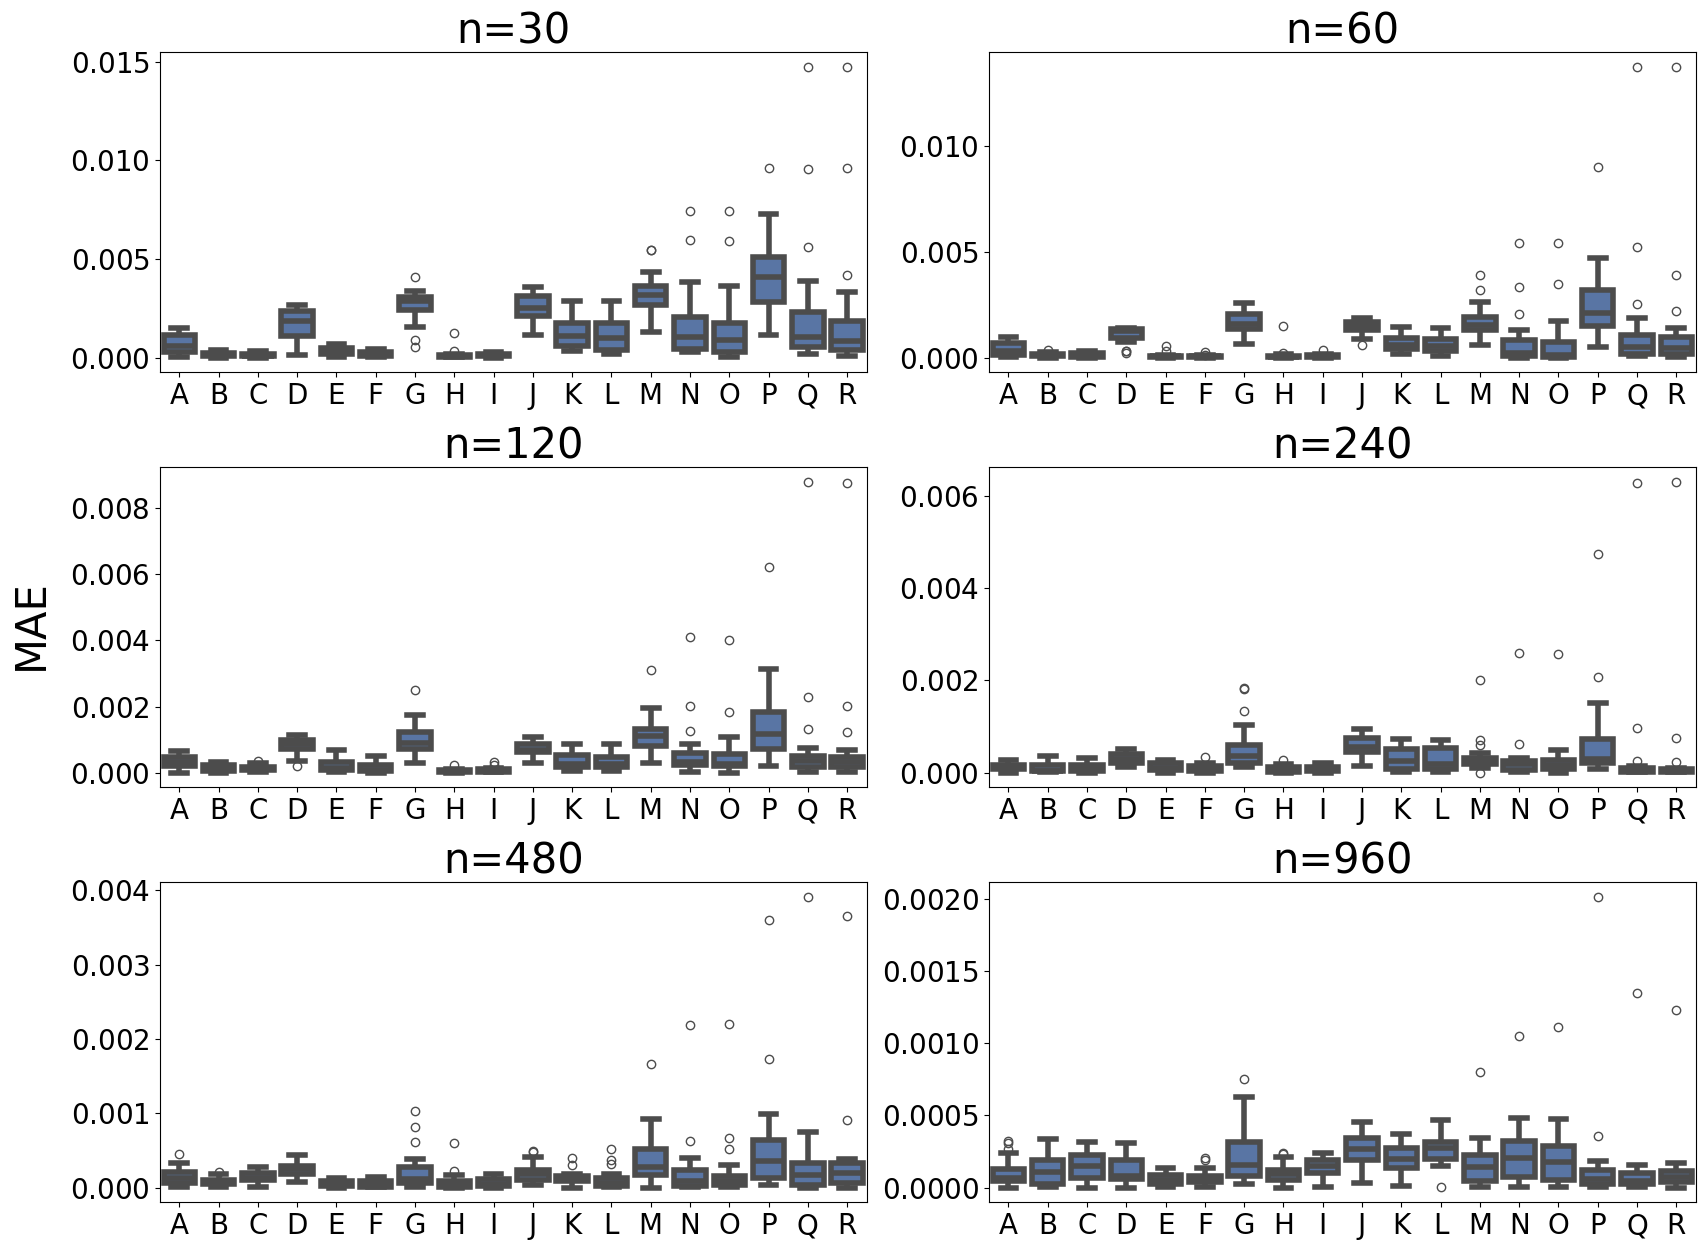

In [9]:

from matplotlib.ticker import ScalarFormatter

alphas = sorted(df_mr["alpha"].unique())
ks = sorted(df_mr["K"].unique())

labels_irm = ['A','B','C','D','E','F','G','H','I']
# labels_he  = ['J','K','L','M','N','O','P','Q','R']
labels_ph2 = ['J','K','L','M','N','O','P','Q','R']
# labels = labels_irm + labels_he + labels_ph2
labels = labels_irm + labels_ph2

# wkls = ['IRM', 'HE', 'PH2']
wkls = ['IRM', 'PH2']
pairs = list(itertools.product(wkls, alphas, ks))

sns.set_palette("deep")
font_axes = 30
font_ticks = 20
line_width = 4
palette = sns.color_palette("deep", len(labels))
color_map = dict(zip(labels, palette))

mapping = {pk: lab for pk, lab in zip(pairs, labels)}
order = labels

rows = []
for r in df_err.itertuples():
    rows.append({
        "m": r.m, "n": r.n, "C": r.C,
        "workload": "IRM",
        "error": r.error_irm,
        "method_param": ("IRM", r.alpha, r.K)
    })
    # rows.append({
    #     "m": r.m, "n": r.n, "C": r.C,
    #     "workload": "HE",
    #     "error": r.error_he,
    #     "method_param": ("HE", r.alpha, r.K)
    # })
    rows.append({
        "m": r.m, "n": r.n, "C": r.C,
        "workload": "PH2",
        "error": r.error_ph2,
        "method_param": ("PH2", r.alpha, r.K)
    })
df_err_long = pd.DataFrame(rows)
df_err_long["short"] = df_err_long["method_param"].map(mapping)

M_list = ms
n_list = ns

subplot_rows, subplot_cols = 3, 2
fig2, axes2 = plt.subplots(subplot_rows, subplot_cols, figsize=(18, 14),
                           sharex=False, sharey=False)
axes_flat = axes2.flatten()

for ax2, (M, n) in zip(axes_flat, itertools.product(M_list, n_list)):
    cell = df_err_long[(df_err_long.m == M) & (df_err_long.n == n)].copy()
    sns.boxplot(x='short', y='error', data=cell, ax=ax2,
                linewidth=line_width, order=order)
    ax2.set_title(f"n={M}", fontsize=font_axes)
    ax2.tick_params(labelsize=font_ticks)
    ax2.set_xlabel('')
    ax2.set_ylabel('')
    ax2.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    ax2.set_xticklabels(order, fontsize=font_ticks, rotation=0)

fig2.text(0.025, 0.5, 'MAE', va='center', rotation='vertical',
          fontsize=font_axes)

plt.tight_layout(rect=[0.05, 0.05, 0.97, 0.95])
plt.savefig("figures/ranclock-maes.pdf", bbox_inches='tight')


In [9]:
df_mr.to_csv("mrcs.csv", index=False)
df_err.to_csv("maes.csv", index=False)